In [9]:
import importlib
import torch
import Data_Prep
importlib.reload(Data_Prep)
from Data_Prep import Data_Prep, Player_IO
import Prep_Map
importlib.reload(Prep_Map)
import Output_Map
importlib.reload(Output_Map)
import Player_Dataset
importlib.reload(Player_Dataset)
from Player_Dataset import Player_Dataset, Create_Test_Train_Datasets

In [10]:
data_prep = Data_Prep(Prep_Map.base_prep_map, Output_Map.base_output_map)
hitter_io_list = data_prep.Generate_IO_Hitters("WHERE lastMLBSeason<? AND signingYear<? AND isHitter=?", (2025,2015,1), use_cutoff=True)
train_dataset, test_dataset = Create_Test_Train_Datasets(hitter_io_list, 0.25, 0)

Train Model

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Num. Parameters: 23842
Epoch [1/150], Train Loss: 22.1383, Test Loss: 6.2101
Epoch [11/150], Train Loss: 3.7343, Test Loss: 3.9319
Epoch [21/150], Train Loss: 3.7078, Test Loss: 3.8928
Epoch [31/150], Train Loss: 3.7032, Test Loss: 3.8960
Epoch [41/150], Train Loss: 3.6847, Test Loss: 3.9462
Epoch [51/150], Train Loss: 3.6998, Test Loss: 3.9026
Epoch [61/150], Train Loss: 3.6653, Test Loss: 3.9151
Epoch [71/150], Train Loss: 3.6905, Test Loss: 3.8822
Epoch [81/150], Train Loss: 3.6839, Test Loss: 3.8965
Epoch [91/150], Train Loss: 3.7404, Test Loss: 3.8781
Epoch [101/150], Train Loss: 3.6548, Test Loss: 3.8676
Epoch [111/150], Train Loss: 3.6506, Test Loss: 3.8772
Epoch [121/150], Train Loss: 3.6433, Test Loss: 3.8572
Epoch [131/150], Train Loss: 3.6429, Test Loss: 3.8417
Epoch [141/150], Train Loss: 3.6320, Test Loss: 3.8447
Best result at epoch=137 with loss=3.835962844174439


3.835962844174439

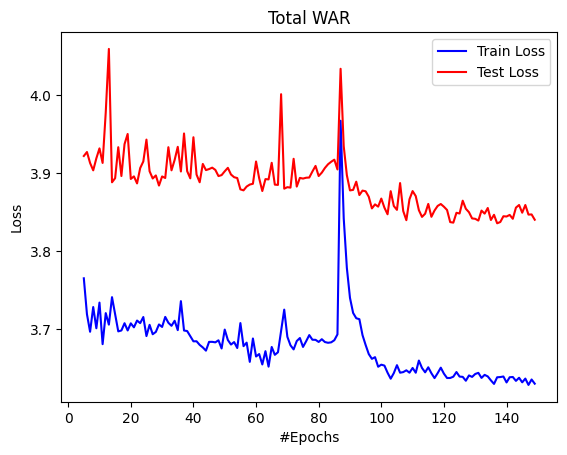

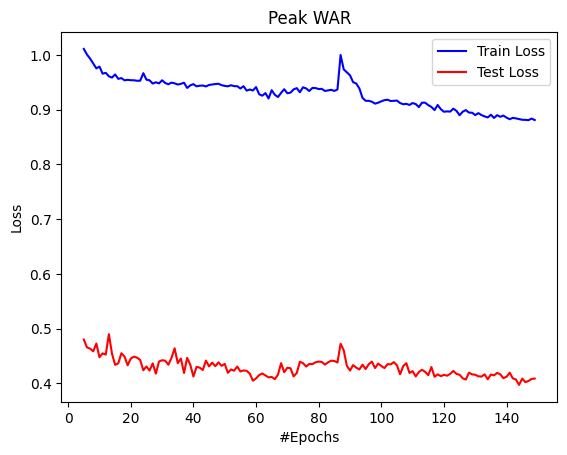

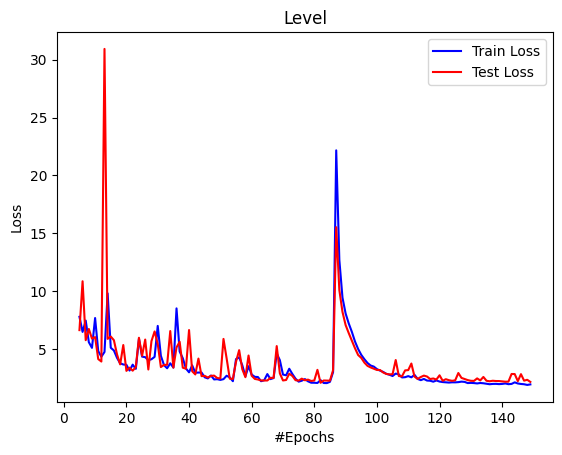

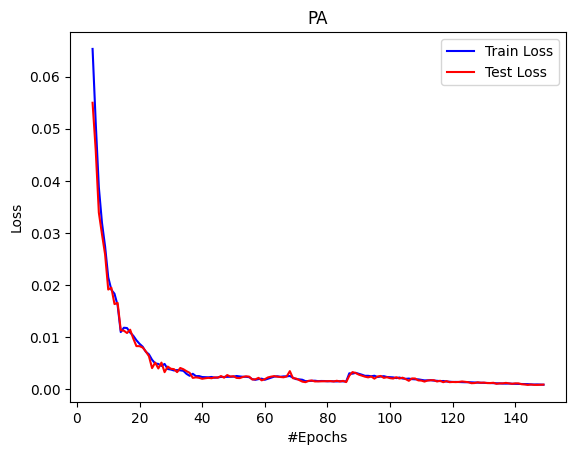

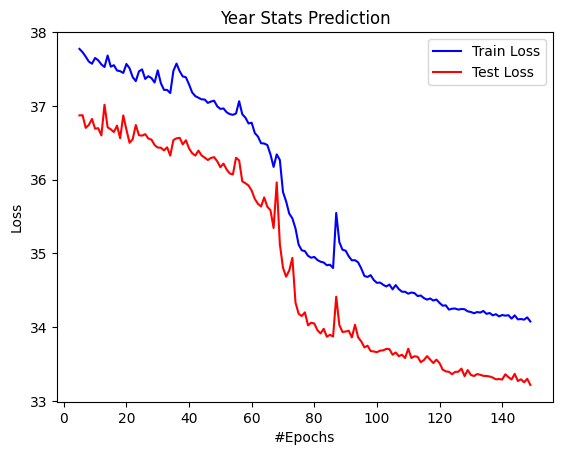

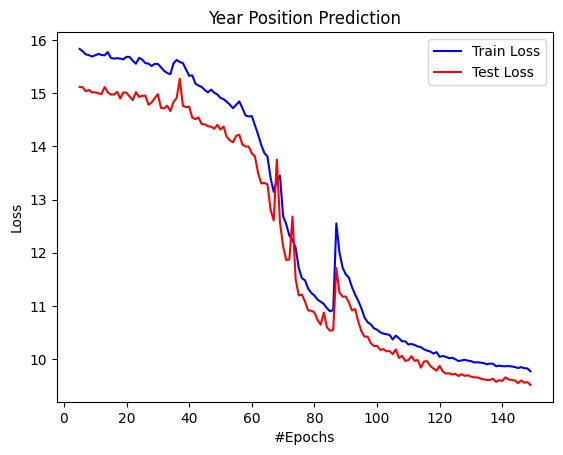

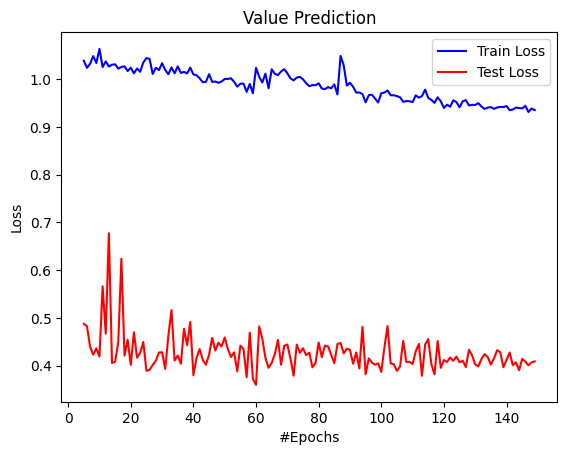

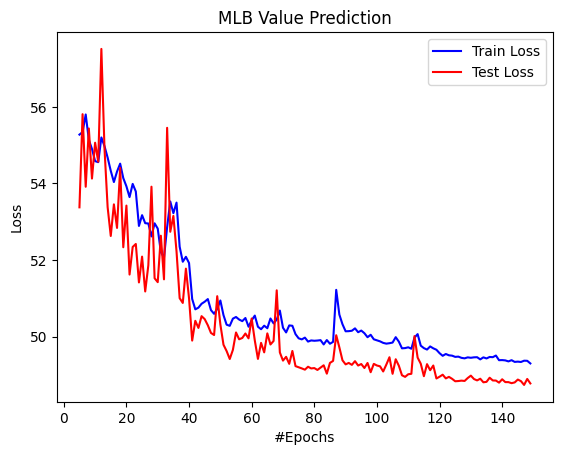

In [ ]:
import Player_Model
importlib.reload(Player_Model)
from Player_Model import RNN_Model
from torch.optim import lr_scheduler
import Model_Train
importlib.reload(Model_Train)
from Model_Train import trainAndGraph
from Constants import device, DEFAULT_NUM_LAYERS_HITTER, DEFAULT_HIDDEN_SIZE_HITTER

batch_size = 200
hitting_mutators = data_prep.Generate_Hitting_Mutators(batch_size, Player_IO.GetMaxLength(hitter_io_list))

num_layers = DEFAULT_NUM_LAYERS_HITTER
hidden_size = DEFAULT_HIDDEN_SIZE_HITTER
network = RNN_Model(train_dataset.get_input_size(), num_layers, hidden_size, hitting_mutators, data_prep=data_prep, is_hitter=True)
network = network.to(device)

print("Num. Parameters:", count_parameters(network))

optimizer = torch.optim.Adam(network.parameters(), lr=0.0025)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, cooldown=10, verbose=False)

num_epochs = 80
training_generator = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

trainAndGraph(network, training_generator, testing_generator, len(train_dataset), len(test_dataset), optimizer, scheduler, num_epochs, logging_interval=10, early_stopping_cutoff=2000, should_output=True, model_name="Models/default_hitter.pt", save_last=True)

Testing

In [13]:
import torch.nn as nn
import sqlite3
from tqdm import tqdm
test_db = sqlite3.connect('test.db')

In [14]:
network.load_state_dict(torch.load("Models/default_hitter.pt"))
network.eval()
network = network.to(device)

In [15]:
cursor = test_db.cursor()
cursor.execute("DELETE FROM StatPred")
cursor.execute("DELETE FROM StatAct")
cursor.execute("DELETE FROM MlbValuePredH")
cursor.execute("DELETE FROM MlbValueActH")
test_db.commit()

softmax = nn.Softmax(dim=0)

mlb_value_mean : torch.Tensor = data_prep.__getattribute__('__hittervalues_means').to(device)
mlb_value_stds : torch.Tensor = data_prep.__getattribute__('__hittervalues_devs').to(device)

for io in tqdm(hitter_io_list):
    hitter = io.player
    input = io.input.unsqueeze(0)  
    output = io.output
    l = torch.tensor([input.shape[1]])
    twar, pwar, level, pa, value, year_stats, year_positions, mlb_value = network(input.to(device), l.to(device))
    
    mlb_value = mlb_value.squeeze(0)
    mlb_value_norm = (mlb_value * mlb_value_stds) + mlb_value_mean
    
    mlb_value_act = (io.mlb_value_stats.to(device) * mlb_value_stds) + mlb_value_mean
    for i in range(io.year_stat_output.size(0)):
        year_position_probs = softmax(year_positions.squeeze(0)[i,:9])
        test_db.execute("INSERT INTO StatPred VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)", (hitter.mlbId, 1, 1, io.dates[i,1].item(), io.dates[i,2].item()) + tuple(year_stats.squeeze(0)[i,:11].tolist()) + tuple(year_position_probs.tolist()))
        test_db.execute("INSERT INTO StatAct VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)", (hitter.mlbId, 1, 1, io.dates[i,1].item(), io.dates[i,2].item()) + tuple(io.year_stat_output[i,:].tolist()) + tuple(io.year_pos_output[i,:].tolist()))
        test_db.execute("INSERT INTO MlbValuePredH VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)", (hitter.mlbId,)  + tuple(io.dates[i,1:3].tolist()) + tuple(mlb_value_norm[i,:].tolist()))
        test_db.execute("INSERT INTO MlbValueActH VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)", (hitter.mlbId,)  + tuple(io.dates[i,1:3].tolist()) + tuple(mlb_value_act[i,:].tolist()))
test_db.commit()

100%|██████████| 8871/8871 [02:16<00:00, 64.89it/s]


Statsonly pretraining

In [ ]:
data_prep = Data_Prep(Prep_Map.statsonly_prep_map, Output_Map.base_output_map)
hitter_io_list = data_prep.Generate_IO_Hitters("WHERE lastMLBSeason<? AND signingYear<? AND isHitter=?", (2025,2015,1), use_cutoff=True)
train_dataset, test_dataset = Create_Test_Train_Datasets(hitter_io_list, 0.25, 0)

In [ ]:
batch_size = 200
hitting_mutators = data_prep.Generate_Hitting_Mutators(batch_size, Player_IO.GetMaxLength(hitter_io_list))

num_layers = DEFAULT_NUM_LAYERS_HITTER
hidden_size = DEFAULT_HIDDEN_SIZE_HITTER
network = RNN_Model(train_dataset.get_input_size(), num_layers, hidden_size, hitting_mutators, data_prep=data_prep, is_hitter=True)
network = network.to(device)

print("Num. Parameters:", count_parameters(network))

optimizer = torch.optim.Adam(network.parameters(), lr=0.0025)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, cooldown=10, verbose=False)

num_epochs = 150
training_generator = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

trainAndGraph(network, training_generator, testing_generator, len(train_dataset), len(test_dataset), optimizer, scheduler, num_epochs, logging_interval=10, early_stopping_cutoff=2000, should_output=True, model_name="Models/default_statsonly_hitter.pt", save_last=True)